In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Use `engine.execute` to select and display the max date data from the measurement table. We will need this for the next calculation
engine.execute("SELECT MAX (date) FROM measurement").fetchall()

[('2017-08-23',)]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


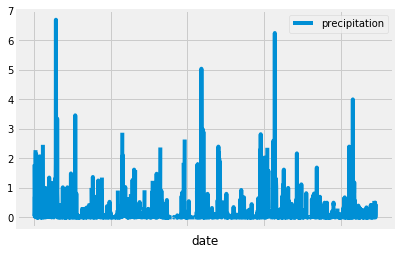

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastyr = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
timeline = Measurement.date >= lastyr
scores = session.query(Measurement.date, Measurement.prcp).filter(timeline).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
qresults = pd.DataFrame(scores, columns=['date', 'precipitation'])
qresults.set_index(qresults["date"], inplace=True)

# Sort the dataframe by date
qresults = qresults.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
qresults.plot()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
qresults.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stationum = session.query(func.count(Station.station)).all()
print("There are " + str(stationum)+ " stations available in this dataset")

There are [(9,)] stations available in this dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# We will use station USC00519281 as noted on the last step.

print("Lowest recorded temp: " + str(session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()))
print("Highest recorded temp: " + str(session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()))
print("Average recorded temp: " + str(session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()))

Lowest recorded temp: [(54.0,)]
Highest recorded temp: [(85.0,)]
Average recorded temp: [(71.66378066378067,)]


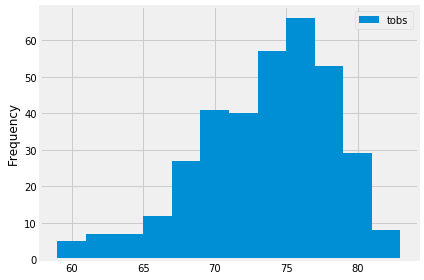

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# We will use station USC00519281 as noted on the last step.

temphist = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").filter(Measurement.date >= lastyr).all()
hist = pd.DataFrame(temphist, columns=["tobs"])
hist.plot.hist(bins=12)
plt.tight_layout()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = dt.date(2017, 8, 1) - dt.timedelta(days=365)
end_date = dt.date(2017, 8, 16) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

71.0 78.15384615384616 83.0


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


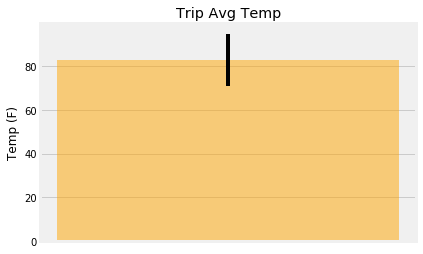

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
xpos = 1
yerr = tmax-tmin

plot = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color="orange")
ax.set(xticks=range(xpos), ylabel="Temp (F)", title="Trip Avg Temp")
fig.show()

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = "2017-08-01"
end_date = "2017-08-16"

data = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

output = session.query(*data).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(output)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.12), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.5), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.33), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.21000000000000002), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.06)]


# Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2017-08-01"
end_date = "2017-08-16"

# Use the start and end date to create a range of dates
drange = pd.date_range(start_date, end_date, freq="D")

# Stip off the year and save a list of %m-%d strings
noyr = drange.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
dnormals = []
for date in noyr:
    dnormals.append(*daily_normals(date))
    
dnormals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip = pd.DataFrame(dnormals, columns=["tmin", "tavg", "tmax"])
trip["date"] = drange
trip.set_index(["date"], inplace=True)
trip.head()

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0


In [24]:
# Not setting .set_index (inplace=True) will leave the default as False and the area graph will not work. Spent a lot of time searching for an answer.
# https://github.com/pandas-dev/pandas/issues/18979
# https://stackoverflow.com/questions/41494942/pandas-dataframe-groupby-plot

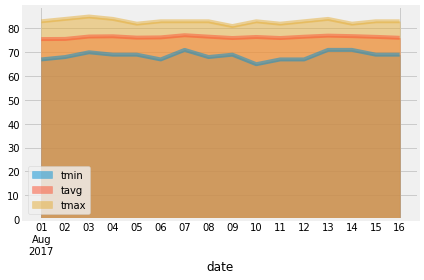

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
trip.plot(kind="area", stacked=False)
plt.tight_layout()